In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import os

env_path = '../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
project = hopsworks.login(project='AMomozZz', api_key_value=HOPSWORKS_API_KEY)

2024-12-29 17:31:31,438 INFO: Initializing external client
2024-12-29 17:31:31,439 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-29 17:31:37,905 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416


In [3]:
# Retrieve feature groups
fs = project.get_feature_store()

only_exchange_fg = fs.get_feature_group(
    name='only_exchange_feature_group',
    version=1,
)

In [4]:
# Select features for training data.
selected_features = only_exchange_fg.select_all()
# selected_features.show(10)

# selected_features.read().sort_values(by=['date'], ascending=True).tail(10)

In [5]:
columns_name = selected_features.read().columns.tolist()
filtered_columns = [col for col in columns_name if "_" not in col and col != "date"]
# filtered_columns

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.93s) 


In [6]:
feature_view = fs.get_or_create_feature_view(
    name='exchange_feature_view',
    description="only exchange rate as the target",
    version=1,
    labels=filtered_columns,
    query=selected_features,
)

In [7]:
start_date_test_data = "2024-12-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)
display(X_train, X_test)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.71s) 


,date,aud_1,bgn_1,cad_1,chf_1,czk_1,dkk_1,eur_1,gbp_1,hkd_1,...,hkd_10,huf_10,jpy_10,krw_10,nok_10,nzd_10,pln_10,sek_10,sgd_10,zar_10
0,2006-12-12 00:00:00+00:00,1.2776,1.4843,1.1486,1.20790,21.1720,5.6577,0.75890,0.51317,7.7729,...,7.7749,196.69,116.37,930.85,6.2988,1.4851,2.9184,6.8976,1.5505,7.1887
1,2015-03-09 00:00:00+00:00,1.2761,1.7840,1.2466,0.97601,24.8990,6.7969,0.91216,0.65858,7.7584,...,7.7563,270.04,119.05,1109.43,7.6478,1.3313,3.6950,8.4666,1.3617,11.7110
2,2000-12-21 00:00:00+00:00,1.8225,2.1588,1.5241,1.67370,38.3230,8.2371,1.10390,0.68142,7.7998,...,7.7975,296.57,110.59,1198.00,9.0741,2.3306,4.3867,9.6472,1.7333,7.5770
3,2003-06-12 00:00:00+00:00,1.5134,1.6567,1.3566,1.30900,26.6430,6.3195,0.85121,0.59985,7.7987,...,7.7990,212.59,118.69,1207.00,6.7024,1.7479,3.7455,7.7939,1.7354,8.1839
4,2014-02-04 00:00:00+00:00,1.1369,1.4490,1.1076,0.90576,20.3930,5.5283,0.74085,0.61187,7.8240,...,7.7569,223.87,104.67,1069.93,6.1896,1.2043,3.0793,6.5112,1.2796,10.8554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,2010-07-27 00:00:00+00:00,1.1155,1.5125,1.0359,1.04970,19.4301,5.7634,0.77334,0.64516,7.7684,...,7.7743,221.02,88.27,1212.69,6.3307,1.4035,3.2419,7.4813,1.3809,7.5741
6224,2005-12-01 00:00:00+00:00,1.3531,1.6618,1.1676,1.31570,24.5840,6.3333,0.84969,0.57962,7.7545,...,7.7536,215.73,118.73,1035.50,6.7178,1.4564,3.4002,8.2221,1.7005,6.7123
6225,2002-11-06 00:00:00+00:00,1.7772,1.9445,1.5564,1.45780,30.8740,7.4148,0.99761,0.63976,7.7990,...,7.7990,247.40,123.96,1226.90,7.5719,2.0614,4.1176,9.3504,1.7770,10.2049
6226,2004-01-09 00:00:00+00:00,1.2978,1.5480,1.2886,1.24240,25.6160,5.8953,0.79151,0.54975,7.7637,...,0.0000,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,date,aud_1,bgn_1,cad_1,chf_1,czk_1,dkk_1,eur_1,gbp_1,hkd_1,...,hkd_10,huf_10,jpy_10,krw_10,nok_10,nzd_10,pln_10,sek_10,sgd_10,zar_10
641,2024-12-24 00:00:00+00:00,1.6037,1.8818,1.4412,0.89830,24.213,7.1769,0.96219,0.79857,7.7703,...,7.7760,390.57,151.74,1431.85,11.1442,1.7178,4.0541,10.9561,1.3411,17.8782
754,2024-12-23 00:00:00+00:00,1.6048,1.8824,1.4385,0.89480,24.178,7.1813,0.96246,0.79851,7.7724,...,7.7748,389.15,150.83,1432.14,11.1123,1.7061,4.0304,10.9160,1.3396,17.8194
1202,2024-12-27 00:00:00+00:00,0.0000,0.0000,0.0000,0.00000,0.000,0.0000,0.00000,0.00000,0.0000,...,7.7750,388.76,153.50,1433.33,11.1008,1.7321,4.0543,10.9479,1.3472,17.8866
1375,2024-12-11 00:00:00+00:00,1.5628,1.8579,1.4162,0.88031,23.842,7.0844,0.94994,0.78422,7.7760,...,7.7817,391.30,151.60,1392.39,11.1006,1.6991,4.0946,10.9477,1.3434,18.1456
1452,2024-12-18 00:00:00+00:00,1.5764,1.8632,1.4285,0.89673,23.877,7.1058,0.95265,0.78735,7.7709,...,7.7840,394.96,151.15,1417.54,11.0756,1.7144,4.0858,11.0065,1.3472,18.1738
1776,2024-12-12 00:00:00+00:00,1.5728,1.8614,1.4186,0.88322,23.905,7.0976,0.95175,0.78479,7.7736,...,7.7828,391.61,151.67,1396.59,11.0643,1.6991,4.0884,10.9443,1.3437,18.1522
1778,2024-12-10 00:00:00+00:00,1.5500,1.8507,1.4117,0.87954,23.744,7.0570,0.94625,0.78354,7.7748,...,7.7808,390.59,153.14,1395.45,11.1020,1.7069,4.0967,10.9513,1.3451,18.0889
1783,2024-12-13 00:00:00+00:00,1.5645,1.8643,1.4169,0.88829,23.892,7.1092,0.95320,0.78570,7.7757,...,7.7837,389.84,150.20,1397.57,11.0590,1.6922,4.0674,10.9051,1.3406,18.0626
2150,2024-12-17 00:00:00+00:00,1.5727,1.8630,1.4249,0.89274,23.848,7.1050,0.95256,0.79010,7.7753,...,7.7833,394.45,149.64,1403.06,11.0626,1.7002,4.0880,11.0117,1.3451,18.1035
2705,2024-12-06 00:00:00+00:00,1.5538,1.8556,1.4050,0.88283,23.858,7.0758,0.94877,0.78558,7.7824,...,7.7845,394.86,154.48,1406.48,11.1103,1.7119,4.1657,11.0959,1.3479,18.0505


In [9]:
# Drop the index columns - 'date' (event_time)
train_features = X_train.drop(['date'], axis=1)
test_features = X_test.drop(['date'], axis=1)

In [10]:
y_train

,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,huf,jpy,krw,nok,nzd,pln,sek,sgd,zar
0,1.2723,1.4767,1.1512,1.20270,21.0700,5.6289,0.75506,0.50936,7.7730,191.77,116.99,922.60,6.1401,1.4486,2.8799,6.8412,1.5411,6.9958
1,1.2931,1.8009,1.2591,0.98444,25.0930,6.8604,0.92081,0.66169,7.7591,281.04,120.91,1113.45,7.8992,1.3564,3.7920,8.4590,1.3793,12.0885
2,1.8128,2.1375,1.5224,1.66670,38.0730,8.1599,1.09340,0.67571,7.7995,289.14,111.93,1227.30,8.9405,2.2775,4.2169,9.5424,1.7305,7.6325
3,1.5081,1.6589,1.3536,1.31110,26.6620,6.3267,0.85222,0.59839,7.7990,220.26,117.73,1193.30,6.9840,1.7300,3.7971,7.7479,1.7373,7.9921
4,1.1240,1.4467,1.1073,0.90354,20.3640,5.5199,0.73970,0.61325,7.7646,228.80,101.38,1081.64,6.3022,1.2257,3.1101,6.5264,1.2687,11.1180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,1.1050,1.5007,1.0268,1.05690,19.2511,5.7186,0.76728,0.64314,7.7660,217.71,87.31,1181.48,6.1379,1.3552,3.0726,7.2596,1.3605,7.3030
6224,1.3497,1.6650,1.1684,1.31690,24.6560,6.3462,0.85143,0.57880,7.7550,215.62,120.20,1034.65,6.7876,1.4190,3.3291,8.1024,1.6897,6.4773
6225,1.7836,1.9570,1.5577,1.46990,30.9310,7.4653,1.00450,0.64229,7.7994,240.73,122.39,1225.00,7.3928,2.0190,3.9816,9.1688,1.7620,9.9100
6226,1.2910,1.5354,1.2783,1.23000,25.5240,5.8474,0.78511,0.54518,7.7631,210.57,106.92,1181.60,6.7893,1.4708,3.6852,7.1539,1.6947,6.7704


In [11]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

MSE: 59.03752439252561
R squared: -1.3186805804256696


In [13]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 10],
#     'n_estimators': [100, 200, 500],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
# grid_search.fit(train_features, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

In [14]:
y_test

,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,huf,jpy,krw,nok,nzd,pln,sek,sgd,zar
641,1.6047,1.8815,1.4418,0.90024,24.180,7.1773,0.96200,0.79658,7.7675,396.08,157.05,1458.37,11.3987,1.7729,4.1092,11.0952,1.3592,18.5948
754,1.6037,1.8818,1.4412,0.89830,24.213,7.1769,0.96219,0.79857,7.7703,399.02,157.18,1453.44,11.3605,1.7732,4.1136,11.0497,1.3570,18.4780
1202,1.6078,1.8743,1.4377,0.90043,24.150,7.1492,0.95831,0.79634,7.7614,394.30,157.79,1473.55,11.3498,1.7736,4.0971,11.0010,1.3583,18.7119
1375,1.5728,1.8614,1.4186,0.88322,23.905,7.0976,0.95175,0.78479,7.7736,389.72,152.61,1430.36,11.1469,1.7303,4.0585,10.9608,1.3433,17.7781
1452,1.5817,1.8634,1.4312,0.89386,23.940,7.1080,0.95274,0.78620,7.7709,391.46,153.89,1438.15,11.2062,1.7438,4.0566,10.9466,1.3507,18.0642
1776,1.5645,1.8643,1.4169,0.88829,23.892,7.1092,0.95320,0.78570,7.7757,389.33,152.13,1430.72,11.1086,1.7266,4.0757,10.9618,1.3448,17.6939
1778,1.5628,1.8579,1.4162,0.88031,23.842,7.0844,0.94994,0.78422,7.7760,390.57,151.74,1431.85,11.1442,1.7178,4.0541,10.9561,1.3411,17.8782
1783,1.5676,1.8595,1.4218,0.89228,23.787,7.0898,0.95075,0.78953,7.7750,388.76,153.50,1433.33,11.1008,1.7321,4.0543,10.9479,1.3472,17.8866
2150,1.5764,1.8632,1.4285,0.89673,23.877,7.1058,0.95265,0.78735,7.7709,390.06,153.98,1436.72,11.2065,1.7366,4.0616,10.9288,1.3510,18.1286
2705,1.5600,1.8484,1.4065,0.87742,23.731,7.0489,0.94509,0.78305,7.7794,391.60,150.51,1419.74,11.0996,1.7118,4.0327,10.8903,1.3396,18.0584


In [15]:
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred

,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,huf,jpy,krw,nok,nzd,pln,sek,sgd,zar
0,1.608672,1.855919,1.412642,0.933110,23.989870,7.108182,0.943293,0.796589,7.772426,397.083588,156.378204,1435.519409,11.076799,1.740298,4.088781,11.015624,1.354984,18.670582
1,1.555761,1.858104,1.413390,0.930822,23.988184,7.098576,0.946533,0.787477,7.773359,397.198334,156.240097,1434.662842,11.068521,1.755951,4.095784,11.015624,1.357228,18.226568
2,1.541141,1.838320,1.379623,0.897305,24.417318,6.989988,0.950156,0.789757,7.770858,367.428192,148.342514,1355.118408,10.800416,1.702571,4.054369,10.695471,1.360273,18.786877
3,1.550492,1.853214,1.411731,0.882473,23.774904,7.066910,0.949146,0.783694,7.776243,391.346710,150.060974,1427.260010,11.061857,1.721091,4.032883,10.923520,1.341004,17.955288
4,1.560952,1.864146,1.411592,0.934868,23.753832,7.065036,0.946299,0.785943,7.775051,390.951263,153.294754,1428.583008,11.057252,1.729009,4.051342,10.903505,1.351119,18.070646
5,1.567756,1.841419,1.411259,0.921256,23.785583,7.068571,0.948664,0.783604,7.775621,391.306152,152.621811,1403.874023,11.059237,1.736973,4.040985,10.960376,1.342855,17.663441
6,1.553199,1.856660,1.409003,0.877186,23.824924,7.060397,0.948820,0.783715,7.777696,391.346710,150.267487,1435.134033,11.061857,1.702077,4.025434,10.949671,1.342531,17.553049
7,1.549680,1.844928,1.415560,0.923252,23.760666,7.067640,0.947947,0.784514,7.778891,391.663483,151.647491,1427.023682,11.059342,1.734085,4.066474,10.924893,1.345545,17.426180
8,1.558518,1.859854,1.412250,0.923941,23.727615,7.065605,0.946018,0.786934,7.776690,392.499542,152.844681,1425.836670,11.096647,1.727071,4.044405,10.893478,1.349199,17.921194
9,1.553145,1.854192,1.398607,0.881555,23.872513,7.051490,0.946455,0.784493,7.783519,390.863922,150.214188,1405.547974,11.025874,1.711029,4.046201,10.955333,1.339946,18.019873


In [16]:
# df = pd.merge(y_test, y_pred, how="left", left_index=True, right_index=True)
# df['date'] = X_test['date']
# df = df.sort_values(by=['date'])
# # df.head(5)

# df

df1 = y_test.copy()
df1['date'] = pd.to_datetime(X_test['date']).dt.date
df1 = df1.sort_values(by=['date'])

df2 = y_pred.copy()
df2['date'] = pd.to_datetime(X_test['date']).dt.date.values
df2 = df2.sort_values(by=['date'])

In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "exchange_predict_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

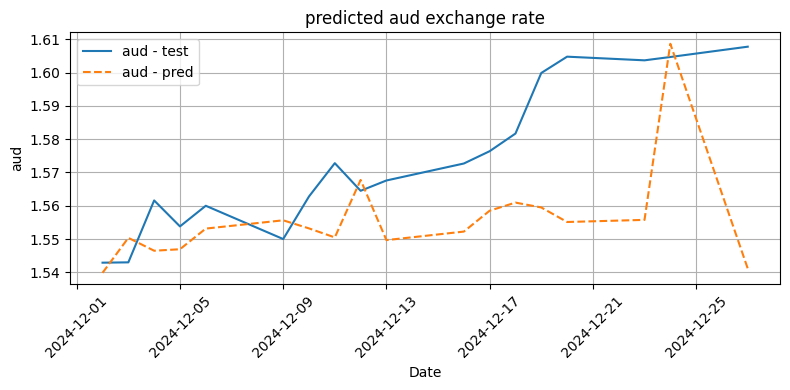

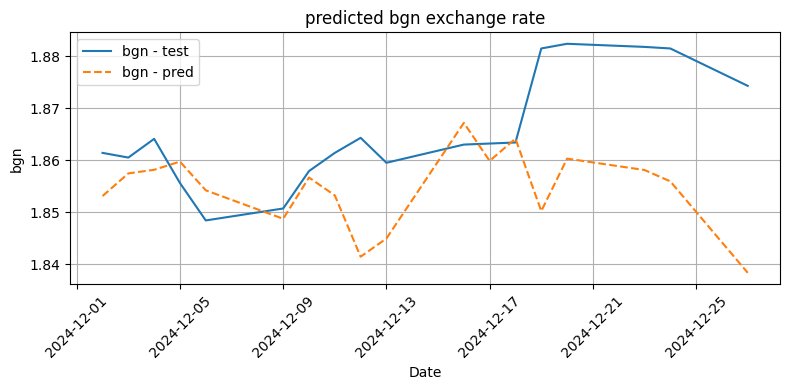

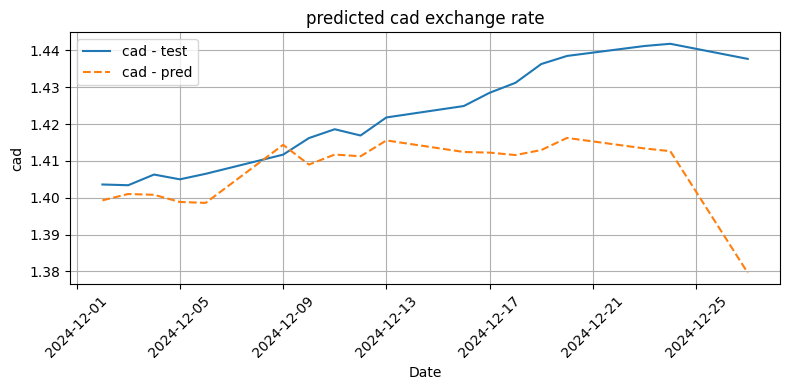

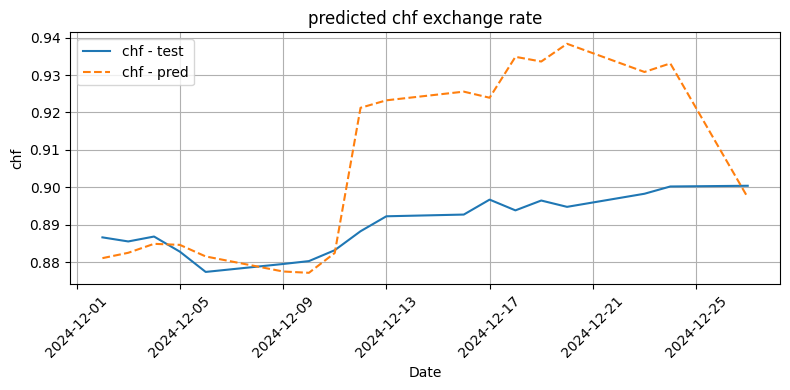

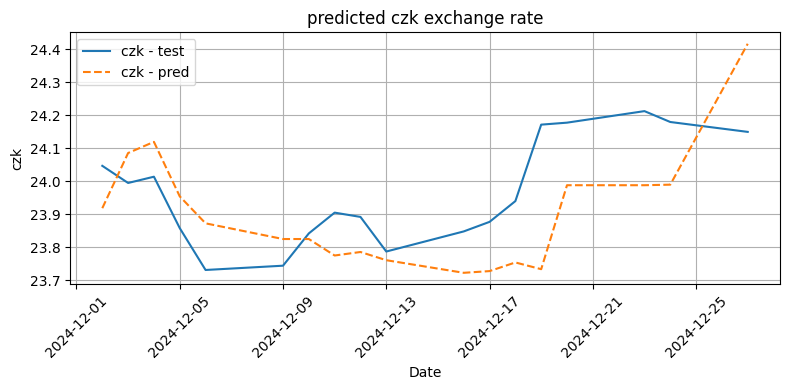

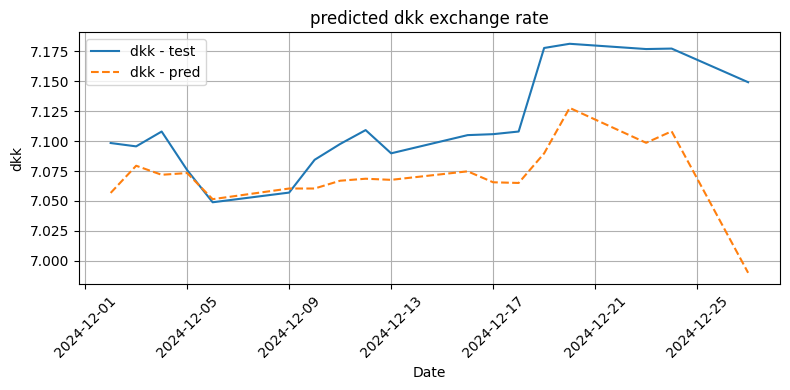

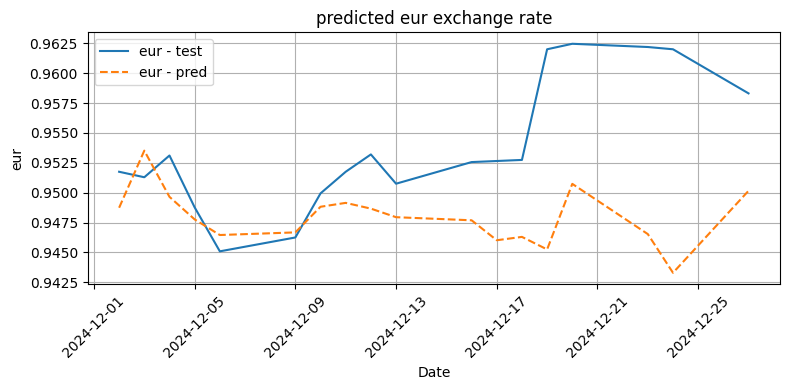

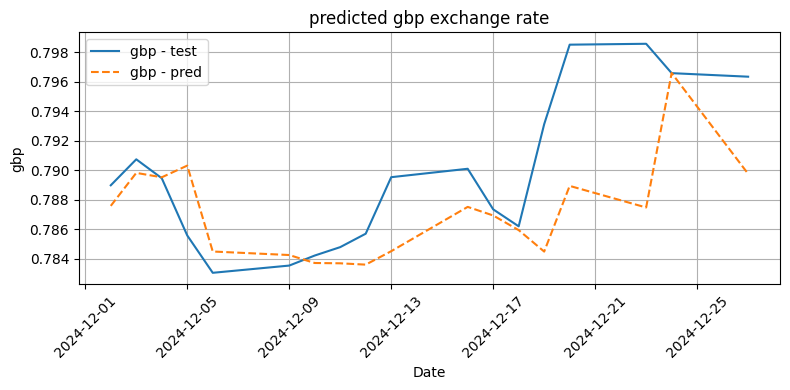

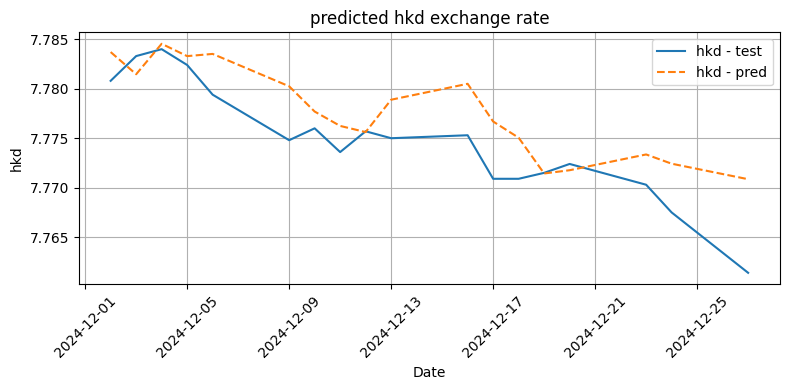

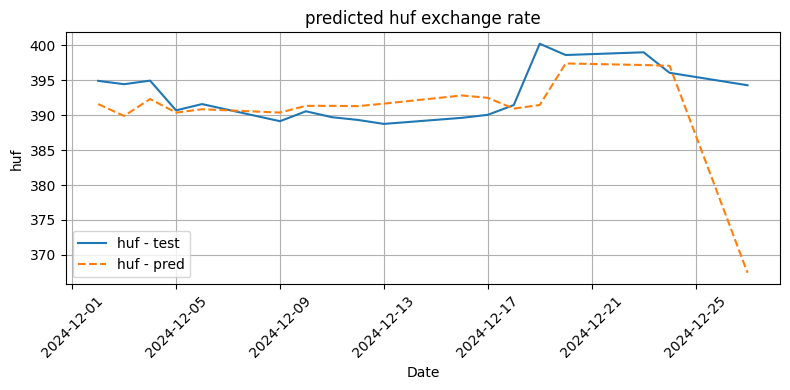

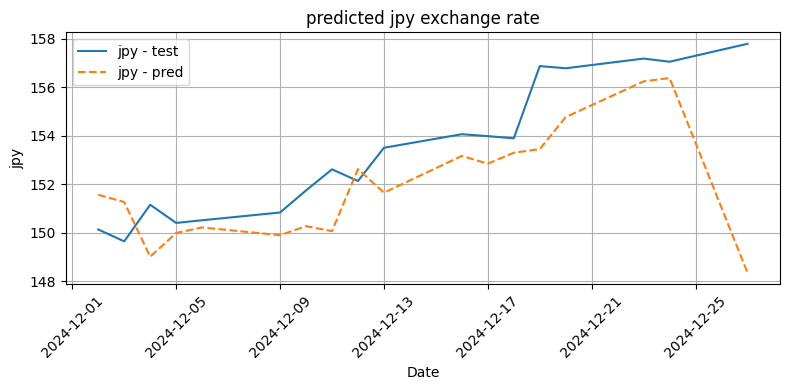

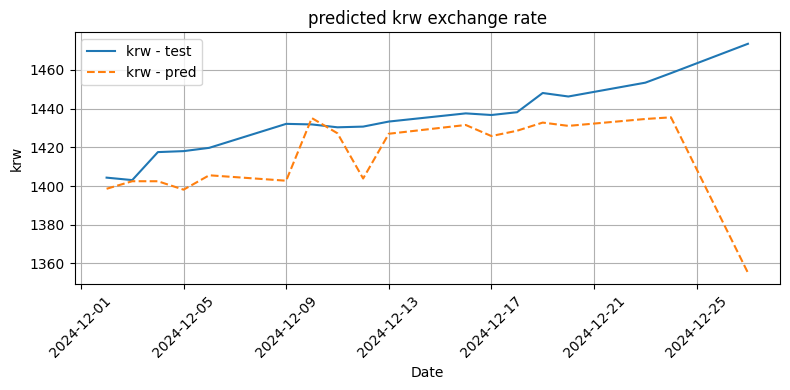

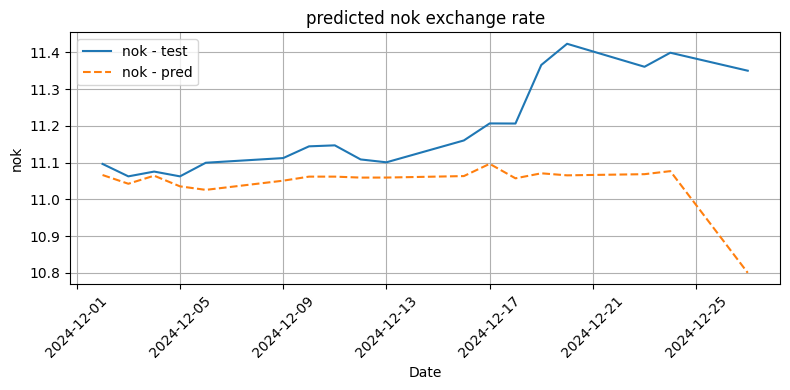

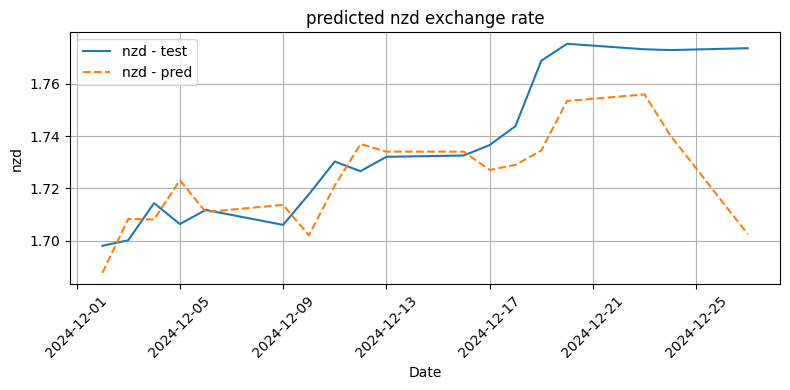

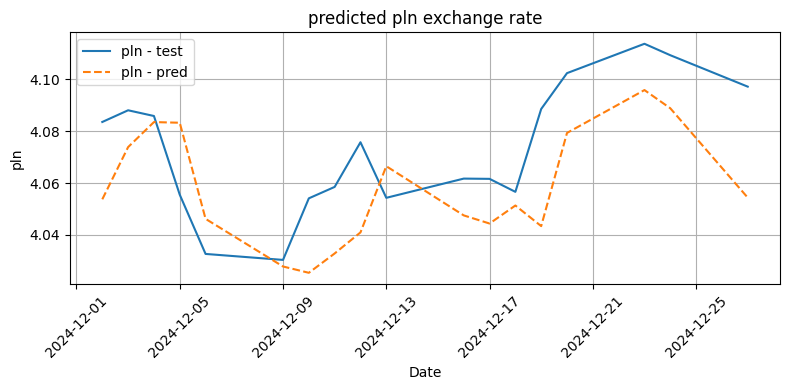

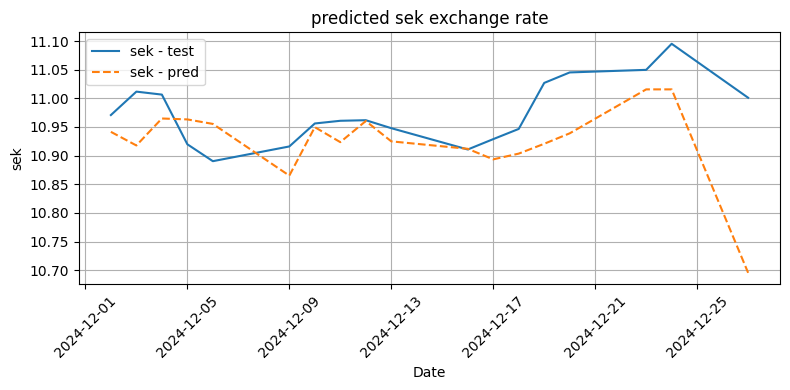

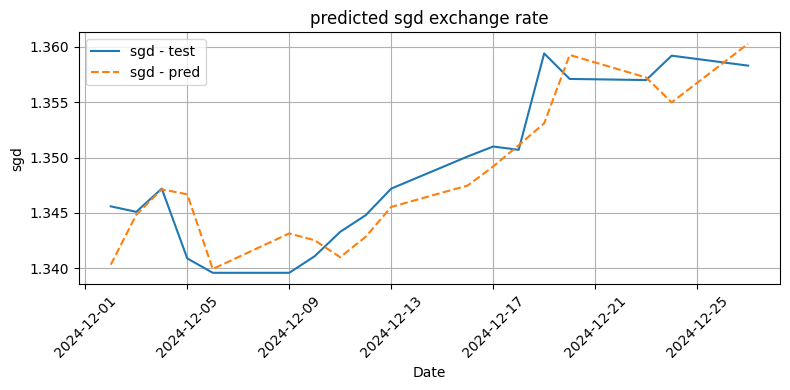

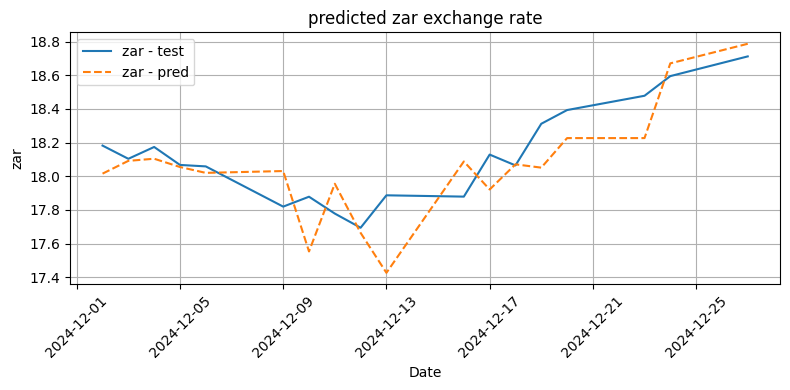

In [18]:
columns_to_plot = df1.columns
for column in [col for col in columns_to_plot if col != 'date']:
    plt.figure(figsize=(8, 4))
    plt.plot(df1["date"], df1[column], label=f"{column} - test")
    plt.plot(df2["date"], df2[column], label=f"{column} - pred", linestyle='dashed')
    plt.title(f"predicted {column} exchange rate")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{images_dir}/{column}_exchange_rate.png")
    plt.show()

In [19]:
# display(weather_fg.features, len(weather_fg.features))

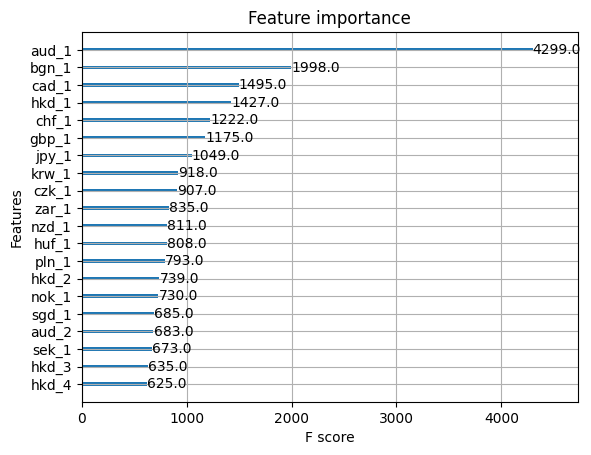

In [27]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=20)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path, bbox_inches='tight')
plt.show()

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [22]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

exchange_model = mr.python.create_model(
    name="exchange_rate_xgboost_model", 
    version=1,
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="exchange rate xgboost model",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
exchange_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/8167481 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42979 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/41014 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/36307 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/38045 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/41415 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/41630 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/46924 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/93812 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45973 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/39529 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/37039 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/38432 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/37146 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/35790 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/36264 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/42815 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43934 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/40638 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/41469 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1523 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/14430 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163416/models/exchange_rate_xgboost_model/1


Model(name: 'exchange_rate_xgboost_model', version: 1)